In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score

In [10]:
# Load data
df = pd.read_csv('steel_industry_data_excerpt.csv')

# Display the first few rows of the DataFrame
print(df.head())

# Display concise summary information about the DataFrame
df.info()

# Display descriptive statistics
print(df.describe())
# Convert 'date' column to datetime if it's not already
df['date'] = pd.to_datetime(df['date'])


                  date  Usage_kWh  Lagging_Current_Reactive.Power_kVarh  \
0  2018-01-01 02:30:00       3.78                                  4.72   
1  2018-01-01 04:15:00       3.28                                  3.82   
2  2018-01-01 05:45:00       3.28                                  3.49   
3  2018-01-01 10:00:00       3.64                                  0.00   
4  2018-01-01 10:30:00       3.71                                  0.00   

   Leading_Current_Reactive_Power_kVarh  CO2(tCO2)  \
0                                  0.00        0.0   
1                                  0.00        0.0   
2                                  0.00        0.0   
3                                 16.88        0.0   
4                                 18.00        0.0   

   Lagging_Current_Power_Factor  Leading_Current_Power_Factor    NSM  \
0                         62.51                        100.00   9000   
1                         65.14                        100.00  15300   
2       

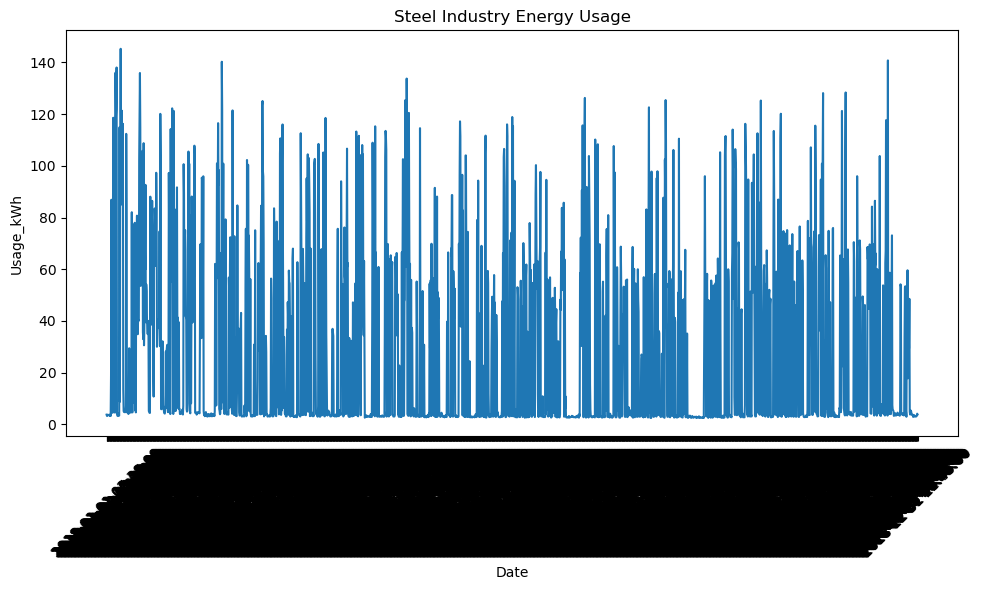

In [11]:
# Use matplotlib to plot the data
plt.figure(figsize=(10, 6))  # Specify the figure size
plt.plot(df['date'], df['Usage_kWh'])  # Plot Usage_kWh against date
plt.xlabel('Date')
plt.ylabel('Usage_kWh')
plt.title('Steel Industry Energy Usage')
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust subplots to give the figure a better fit
plt.show()

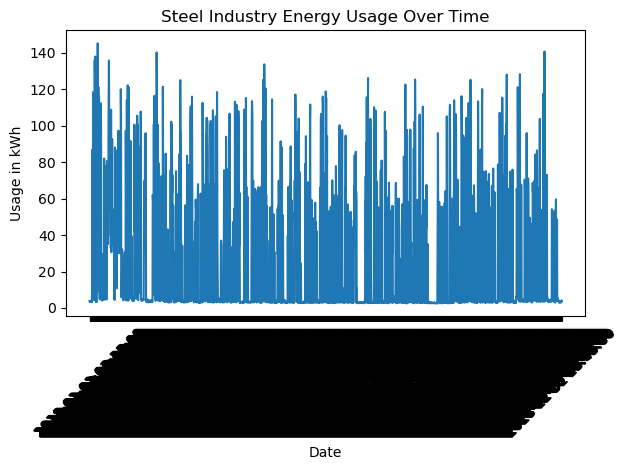

In [12]:
#Seaborn to plot the data
sns.lineplot(x='date', y='Usage_kWh', data=df)
plt.xlabel('Date')  # Label for the x-axis
plt.ylabel('Usage in kWh')  # Label for the y-axis
plt.title('Steel Industry Energy Usage Over Time')  # Title for the plot
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust subplots to give the figure a better fit
plt.show()

In [13]:
# Train the clusters
pipeline_kmeans = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=5, n_init=10))  
])
df_numeric = df.select_dtypes(include=[np.number])  # Selecting only numeric columns for clustering
cluster_labels = pipeline_kmeans.fit_predict(df_numeric)
df['Cluster'] = cluster_labels  # Add cluster labels to your DataFrame for analysis

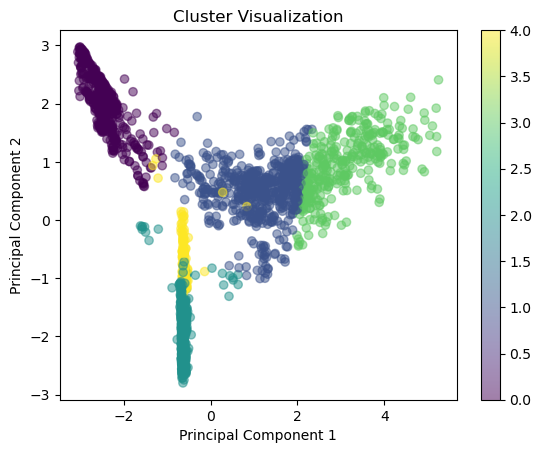

         Usage_kWh  Lagging_Current_Reactive.Power_kVarh  \
Cluster                                                    
0         4.534914                              0.103082   
1        49.236396                             19.800955   
2         3.718664                              4.811543   
3        90.747278                             45.202661   
4         4.036186                              5.090763   

         Leading_Current_Reactive_Power_kVarh  CO2(tCO2)  \
Cluster                                                    
0                                   17.466552   0.000323   
1                                    0.889964   0.022468   
2                                    0.063085   0.000124   
3                                    0.038563   0.041621   
4                                    0.118644   0.000169   

         Lagging_Current_Power_Factor  Leading_Current_Power_Factor  \
Cluster                                                               
0               

In [14]:
# Visualize clusters
pca = PCA(n_components=2)
principal_components = pca.fit_transform(pipeline_kmeans.named_steps['scaler'].transform(df_numeric))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Cluster Visualization')
plt.colorbar()
plt.show()

# Analyze clusters
cluster_analysis = df.select_dtypes(include=[np.number]).groupby('Cluster').mean()
print(cluster_analysis)


In [15]:
# Define and calculate categorical target
mean_usage = df['Usage_kWh'].mean()
df['Usage_kWh_categorical'] = ['High' if x >= mean_usage else 'Low' for x in df['Usage_kWh']]


In [16]:
# Setup and train the classification pipeline
categorical_features = ['WeekStatus', 'Day_of_week']
numeric_features = [col for col in df.columns if col not in ['Usage_kWh', 'Usage_kWh_categorical', 'date', 'Cluster', 'WeekStatus', 'Day_of_week']]
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

pipeline_gb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier())
])

X_class = df.drop(['Usage_kWh', 'Usage_kWh_categorical', 'date', 'Cluster'], axis=1)
y_class = df['Usage_kWh_categorical']
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class, y_class, test_size=0.25, random_state=42)

pipeline_gb.fit(X_train_c, y_train_c)
y_pred_c = pipeline_gb.predict(X_test_c)
print("Accuracy:", accuracy_score(y_test_c, y_pred_c))

Accuracy: 0.9817518248175182
